<a href="https://colab.research.google.com/github/Alii-Tavakolii/Song_Lyrics_Clustering/blob/main/lyrics_clustering_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas scikit-learn sentence-transformers matplotlib seaborn hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/musicLyrics.csv')
print(df.head())
print(df.info())

Mounted at /content/drive
                                               Lyric
0  Cryptic psalms Amidst the howling winds A scor...
1  Im sleeping tonight with all the wolves Were d...
2  Wings of the darkest descent Fall from the rea...
3  [Verse 1] Norrid Radd was my real name Had a j...
4  Deep in the dungeons of doom and despair Sneak...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Lyric   2999 non-null   object
dtypes: object(1)
memory usage: 23.6+ KB
None


### Reason for Text Preprocessing


1.  Noise Reduction by deleting irrelevant characters and focuses on meaningful content.
2.  Standardization by converting words to their common base form.
3.  Reducing Dimensionality by removing stop words ("the", "a", "am" that carry little semantic value)
4.  Presenting a cleaner, more consistent, and relevant representation of the text improves the models accuracy.


### Stemming vs. Lemmatization

Both stemming and lemmatization are techniques used in NLP to reduce words to their base or root form.

* **Stemming:** A faster, rule-based method that chops off word suffixes, often resulting in a form that is not a real word (e.g., "running" $\rightarrow$ "runn"). It's quicker but less precise.
* **Lemmatization:** A more linguistically sophisticated method that reduces words to their dictionary base form (lemma), which is always a valid word (e.g., "running" $\rightarrow$ "run"). It's more accurate but computationally intensive.

For analyzing song lyrics, lemmatization is generally preferred because it preserves more semantic meaning, which is crucial for understanding the themes in the text.

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text, method='lemmatization'):

    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text) # Keep letters and spaces

    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with one, then remove leading/trailing spaces
    text = text.replace('\\n', ' ').replace('\\t', ' ')

    words = text.split()

    words = [word for word in words if word not in stop_words]

    if method == 'stemming':
        words = [stemmer.stem(word) for word in words]
    elif method == 'lemmatization':
        words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)


df['processed_lyrics_lem'] = df['Lyric'].apply(lambda x: preprocess_text(x, method='lemmatization'))
df['processed_lyrics_stem'] = df['Lyric'].apply(lambda x: preprocess_text(x, method='stemming'))


print("\nExamples (Lemmatization):")
print(df[['Lyric', 'processed_lyrics_lem']].head())

print("\nExamples (Stemming):")
print(df[['Lyric', 'processed_lyrics_stem']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Examples (Lemmatization):
                                               Lyric  \
0  Cryptic psalms Amidst the howling winds A scor...   
1  Im sleeping tonight with all the wolves Were d...   
2  Wings of the darkest descent Fall from the rea...   
3  [Verse 1] Norrid Radd was my real name Had a j...   
4  Deep in the dungeons of doom and despair Sneak...   

                                processed_lyrics_lem  
0  cryptic psalm amidst howling wind scorching so...  
1  im sleeping tonight wolf dreaming life thats b...  
2  wing darkest descent fall realm dark blackest ...  
3  verse norrid radd real name job hated every da...  
4  deep dungeon doom despair sneak place dark eke...  

Examples (Stemming):
                                               Lyric  \
0  Cryptic psalms Amidst the howling winds A scor...   
1  Im sleeping tonight with all the wolves Were d...   
2  Wings of the darkest descent Fall from the rea...   
3  [Verse 1] Norrid Radd was my real name Had a j...   
4  D

### Why Feature Extraction?

Machine learning models, including clustering algorithms, cannot directly process raw text. They require numerical input.

Feature extraction transforms raw text (like song lyrics) into numerical representations (vectors) that algorithms can understand and operate on.

It's essential because:
* **Machine Readability:** Algorithms only understand numbers, not words.
* **Meaning Capture:** It converts textual information into a format that captures semantic meaning and context.
* **Mathematical Operations:** Once text is numerical, mathematical operations (e.g., calculating similarities or distances for clustering) become possible.
* **Efficiency:** It creates structured, usable data from unstructured text, which is vital for effective model training and analysis.

In [13]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import pandas as pd

model = SentenceTransformer('all-MiniLM-L6-v2')

df_with_embeddings = df.copy()

lyrics_to_embed_lem = df_with_embeddings['processed_lyrics_lem'].tolist()

sentence_embeddings_lem = model.encode(lyrics_to_embed_lem, show_progress_bar=True)

df_with_embeddings['embeddings_lem'] = list(sentence_embeddings_lem)

lyrics_to_embed_stem = df_with_embeddings['processed_lyrics_stem'].tolist()

sentence_embeddings_stem = model.encode(lyrics_to_embed_stem, show_progress_bar=True)

df_with_embeddings['embeddings_stem'] = list(sentence_embeddings_stem)

print(df_with_embeddings[['Lyric', 'processed_lyrics_lem', 'processed_lyrics_stem', 'embeddings_lem', 'embeddings_stem']].head())
print(f"Number of rows with embeddings (both lemmatized and stemmed): {len(df_with_embeddings)}")

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

                                               Lyric  \
0  Cryptic psalms Amidst the howling winds A scor...   
1  Im sleeping tonight with all the wolves Were d...   
2  Wings of the darkest descent Fall from the rea...   
3  [Verse 1] Norrid Radd was my real name Had a j...   
4  Deep in the dungeons of doom and despair Sneak...   

                                processed_lyrics_lem  \
0  cryptic psalm amidst howling wind scorching so...   
1  im sleeping tonight wolf dreaming life thats b...   
2  wing darkest descent fall realm dark blackest ...   
3  verse norrid radd real name job hated every da...   
4  deep dungeon doom despair sneak place dark eke...   

                               processed_lyrics_stem  \
0  cryptic psalm amidst howl wind scorch sourc ag...   
1  im sleep tonight wolv dream life that better p...   
2  wing darkest descent fall realm dark blackest ...   
3  vers norrid radd real name job hate everi day ...   
4  deep dungeon doom despair sneak place dark 

### Supervised vs. Unsupervised Learning

Machine learning methods are either **Supervised** or **Unsupervised**:

* **Supervised Learning:**
    * **Goal:** Predict outcomes using **labeled data** (input-output pairs).
    * **Examples:** Classification (e.g., spam detection), Regression (e.g., predicting prices).
* **Unsupervised Learning:**
    * **Goal:** Find hidden patterns in **unlabeled data** (input only).
    * **Examples:** Clustering (grouping similar items, as in this project), Dimensionality Reduction (e.g., PCA).

This project uses **clustering**, an **unsupervised learning** technique, to discover natural groupings in song lyrics without predefined categories.

### Elbow Method for K-Means

The **Elbow Method** is a heuristic used to determine the optimal number of clusters ($K$) for K-Means clustering.


1.  **Calculate WCSS:** It involves calculating the **Within-Cluster Sum of Squares (WCSS)** for different values of $K$.
2.  **Plot WCSS vs. K:** Plot the WCSS values against the number of clusters ($K$).
3.  **Identify the "Elbow":** The plot typically resembles an arm, and the "elbow" is the point on the curve where the rate of decrease in WCSS significantly slows down.

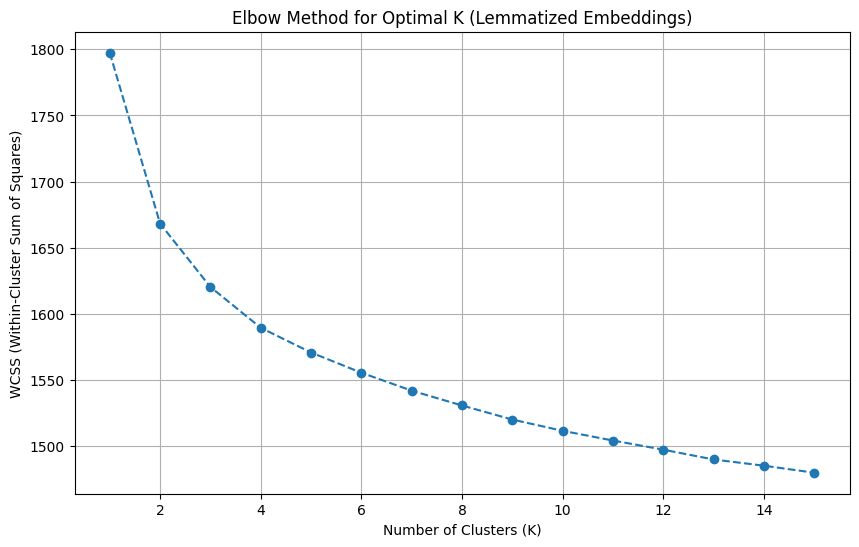

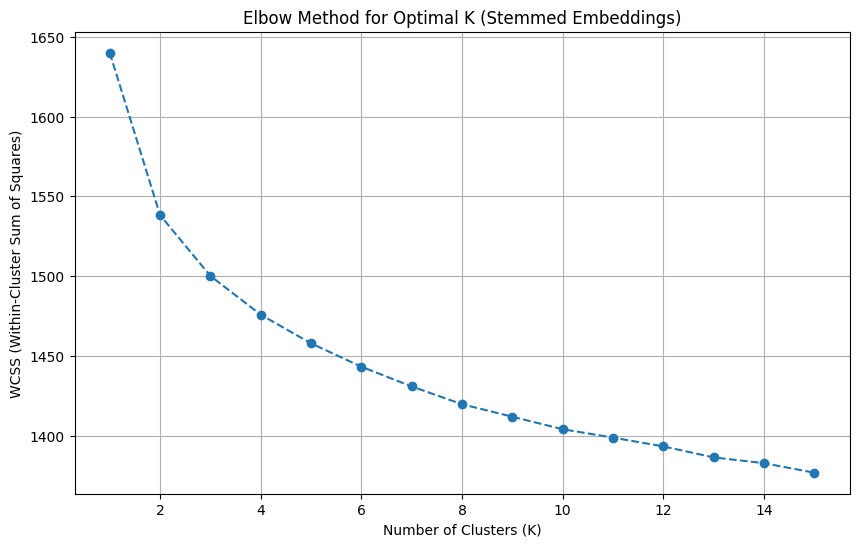

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# --- K-Means for Lemmatized Embeddings ---
X_lem = np.array(df_with_embeddings['embeddings_lem'].tolist())

wcss_lem = []
max_k_lem = 15
for i in range(1, max_k_lem + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_lem)
    wcss_lem.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k_lem + 1), wcss_lem, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (Lemmatized Embeddings)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# --- K-Means for Stemmed Embeddings ---
X_stem = np.array(df_with_embeddings['embeddings_stem'].tolist())

wcss_stem = []
max_k_stem = 15
for i in range(1, max_k_stem + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_stem)
    wcss_stem.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k_stem + 1), wcss_stem, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (Stemmed Embeddings)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [17]:
optimal_k_lem = 4

kmeans_model_lem = KMeans(n_clusters=optimal_k_lem, init='k-means++', max_iter=300, n_init=10, random_state=42)
df_with_embeddings['kmeans_lem_cluster'] = kmeans_model_lem.fit_predict(X_lem)



optimal_k_stem = 3
kmeans_model_stem = KMeans(n_clusters=optimal_k_stem, init='k-means++', max_iter=300, n_init=10, random_state=42)
df_with_embeddings['kmeans_stem_cluster'] = kmeans_model_stem.fit_predict(X_stem)


In [18]:
print("\nFirst few rows with K-Means cluster assignments:")

display_cols_kmeans = ['Lyric', 'kmeans_lem_cluster', 'kmeans_stem_cluster']

print(df_with_embeddings[display_cols_kmeans].head())


First few rows with K-Means cluster assignments:
                                               Lyric  kmeans_lem_cluster  \
0  Cryptic psalms Amidst the howling winds A scor...                   0   
1  Im sleeping tonight with all the wolves Were d...                   3   
2  Wings of the darkest descent Fall from the rea...                   0   
3  [Verse 1] Norrid Radd was my real name Had a j...                   2   
4  Deep in the dungeons of doom and despair Sneak...                   0   

   kmeans_stem_cluster  
0                    0  
1                    1  
2                    0  
3                    0  
4                    0  


In [26]:
import hdbscan
import numpy as np
import pandas as pd

print("\n--- HDBSCAN Clustering ---")

# --- HDBSCAN for Lemmatized Embeddings ---
hdbscan_model_lem = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
labels_lem = hdbscan_model_lem.fit_predict(X_lem)
df_with_embeddings['hdbscan_lem_cluster'] = labels_lem
print("HDBSCAN clustering on Lemmatized Embeddings complete.")

# --- HDBSCAN for Stemmed Embeddings ---
hdbscan_model_stem = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
labels_stem = hdbscan_model_stem.fit_predict(X_stem)
df_with_embeddings['hdbscan_stem_cluster'] = labels_stem


display_cols = ['Lyric', 'hdbscan_lem_cluster', 'hdbscan_stem_cluster']
print(df_with_embeddings[display_cols].head(10))



--- HDBSCAN Clustering ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN clustering on Lemmatized Embeddings complete.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                               Lyric  hdbscan_lem_cluster  \
0  Cryptic psalms Amidst the howling winds A scor...                    1   
1  Im sleeping tonight with all the wolves Were d...                   -1   
2  Wings of the darkest descent Fall from the rea...                    1   
3  [Verse 1] Norrid Radd was my real name Had a j...                    1   
4  Deep in the dungeons of doom and despair Sneak...                    1   
5  Outcast since the day I was born never belonge...                    1   
6  Yeah [Verse 1 Classified] They might say I lea...                    1   
7  girl girl away little girl like girl time catc...                   -1   
8  Your pride Why should your pride be so restric...                   -1   
9  Searching, To fight all the fears in your life...                    1   

   hdbscan_stem_cluster  
0                     0  
1                     0  
2                     0  
3                     0  
4                     

In [27]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd

# --- Hierarchical Clustering for Lemmatized Embeddings ---
X_lem = np.array(df_with_embeddings['embeddings_lem'].tolist())

hierarchical_n_clusters_lem = 4
hierarchical_metric_lem = 'euclidean'
hierarchical_linkage_lem = 'ward'

hierarchical_model_lem = AgglomerativeClustering(n_clusters=hierarchical_n_clusters_lem,
                                                 metric=hierarchical_metric_lem,
                                                 linkage=hierarchical_linkage_lem)
df_with_embeddings['hierarchical_lem_cluster'] = hierarchical_model_lem.fit_predict(X_lem)

# --- Hierarchical Clustering for Stemmed Embeddings ---
X_stem = np.array(df_with_embeddings['embeddings_stem'].tolist())

hierarchical_n_clusters_stem = 3
hierarchical_metric_stem = 'euclidean'
hierarchical_linkage_stem = 'ward'

hierarchical_model_stem = AgglomerativeClustering(n_clusters=hierarchical_n_clusters_stem,
                                                  metric=hierarchical_metric_stem,
                                                  linkage=hierarchical_linkage_stem)
df_with_embeddings['hierarchical_stem_cluster'] = hierarchical_model_stem.fit_predict(X_stem)

display_cols_all_clusters = [
    'Lyric',
    'kmeans_lem_cluster', 'hdbscan_lem_cluster', 'hierarchical_lem_cluster',
    'kmeans_stem_cluster', 'hdbscan_stem_cluster', 'hierarchical_stem_cluster'
]
print(df_with_embeddings[display_cols_all_clusters].head(10))

                                               Lyric  kmeans_lem_cluster  \
0  Cryptic psalms Amidst the howling winds A scor...                   0   
1  Im sleeping tonight with all the wolves Were d...                   3   
2  Wings of the darkest descent Fall from the rea...                   0   
3  [Verse 1] Norrid Radd was my real name Had a j...                   2   
4  Deep in the dungeons of doom and despair Sneak...                   0   
5  Outcast since the day I was born never belonge...                   0   
6  Yeah [Verse 1 Classified] They might say I lea...                   1   
7  girl girl away little girl like girl time catc...                   3   
8  Your pride Why should your pride be so restric...                   1   
9  Searching, To fight all the fears in your life...                   1   

   hdbscan_lem_cluster  hierarchical_lem_cluster  kmeans_stem_cluster  \
0                    1                         2                    0   
1                

K-means and hierarichal worked much better because the space is high dimensional and all points are far from each other and a density-based algorithm like dbscan can't work well.

Sentence Transformers is a framework that turns sentences or text passages into numerical vectors that capture their semantic meaning. The all-MiniLM-L6-v2 is a fast and efficient pre-trained model within this framework, offering a good balance of quality and computational speed.

## Clustering Methods: K-Means, DBSCAN, Hierarchical

### **K-Means**
- Partitions data into **K clusters**.
- Each point belongs to the cluster with the **nearest centroid**.
- Requires pre-defined **K**.
- **Fast and simple**, sensitive to outliers.

---

### **DBSCAN**
- Clusters based on **density of points**.
- Defines clusters as areas with many nearby points.
- Detects **arbitrary-shaped clusters** and **noise (outliers)**.
- No need to specify the number of clusters.
- Requires tuning **ε (epsilon)** and **minPts**.

---

### **Hierarchical Clustering**
- Builds a **tree (dendrogram)** of clusters.
- **Agglomerative**: merges closest points step-by-step.
- **Divisive**: splits big clusters into smaller ones.
- No need to set cluster count upfront.
- Good for understanding data structure, but **computationally expensive**.



## Text Vectorization Methods

### **Bag of Words (BoW)**
- Counts word frequency.
- **+** Simple, fast  
- **-** Ignores order, high-dimensional

---

### **TF-IDF**
- Weights words by importance.
- **+** Highlights key terms  
- **-** Ignores context, sensitive to changes

---

### **Word Embeddings (Word2Vec / GloVe)**
- Maps words to dense vectors.
- **+** Captures meaning, compact  
- **-** Needs large data, domain mismatch possible

---

### **Sentence  Transformers (BERT)**
- Contextual embeddings for sentences.
- **+** Deep understanding, preserves context  
- **-** Slow, resource-heavy


Principal Component Analysis (PCA) is a linear dimensionality reduction technique. It transforms high-dimensional data into fewer dimensions while preserving maximum variance (information). PCA works by identifying main directions of data variance and projecting points onto them. This is crucial for visualizing high-dimensional clusters.

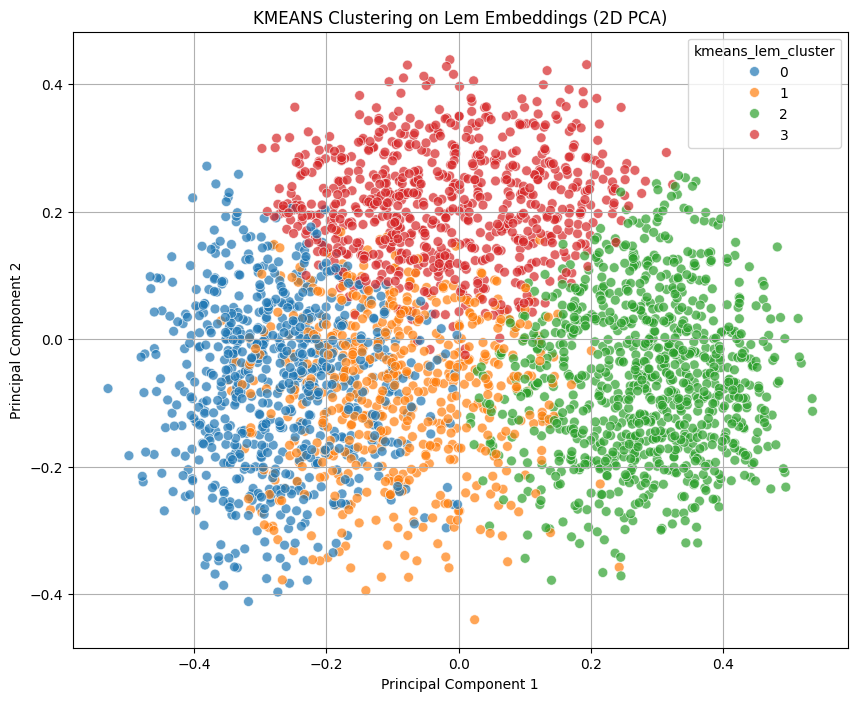

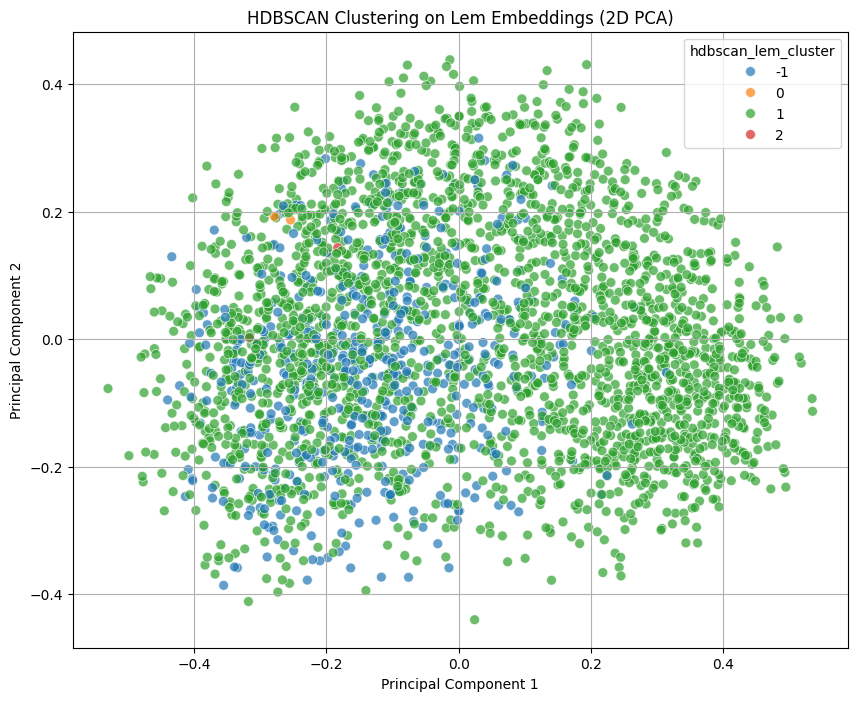

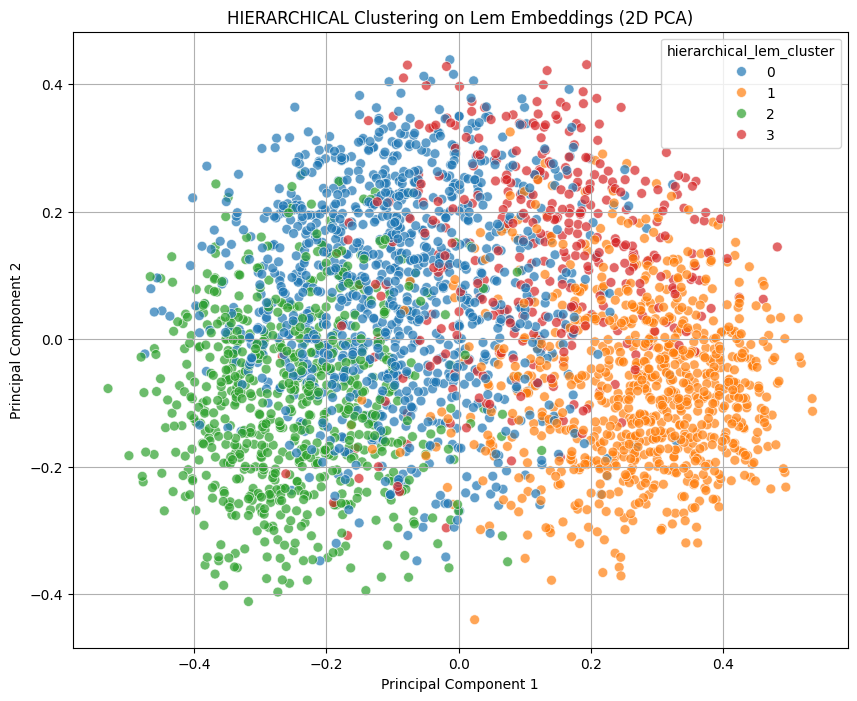

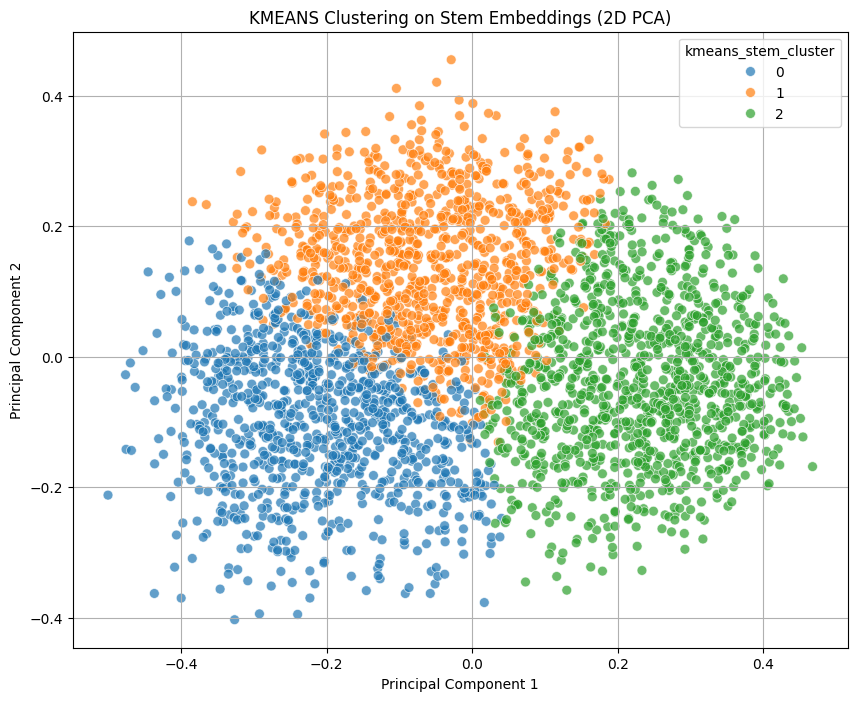

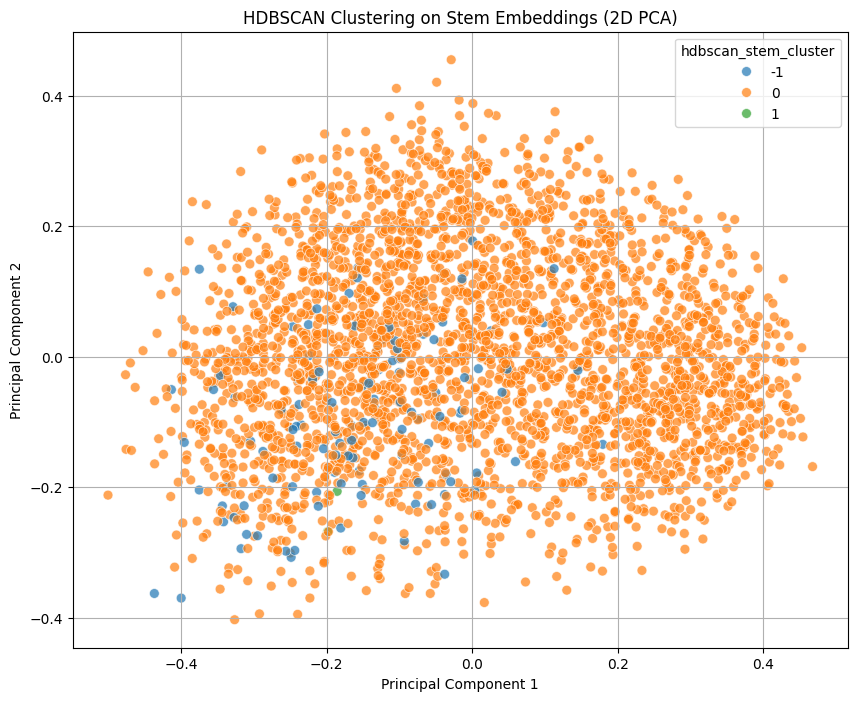

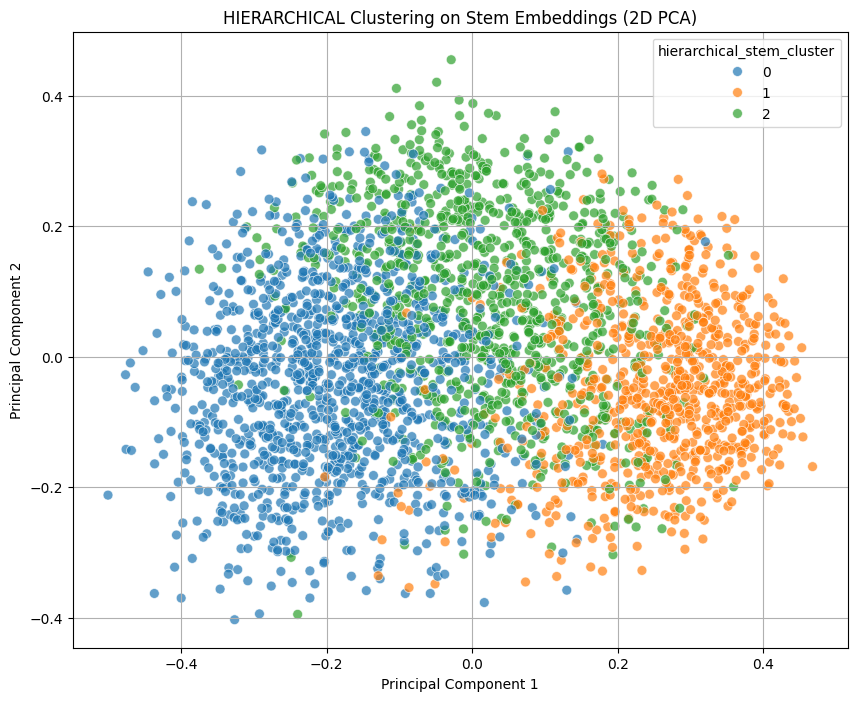

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# --- PCA for Lemmatized Embeddings ---
X_lem = np.array(df_with_embeddings['embeddings_lem'].tolist())

pca_lem = PCA(n_components=2, random_state=42)
components_lem = pca_lem.fit_transform(X_lem)
df_with_embeddings['pca_lem_x'] = components_lem[:, 0]
df_with_embeddings['pca_lem_y'] = components_lem[:, 1]


# --- PCA for Stemmed Embeddings ---
X_stem = np.array(df_with_embeddings['embeddings_stem'].tolist())
pca_stem = PCA(n_components=2, random_state=42)
components_stem = pca_stem.fit_transform(X_stem)
df_with_embeddings['pca_stem_x'] = components_stem[:, 0]
df_with_embeddings['pca_stem_y'] = components_stem[:, 1]


display_cols_pca = ['Lyric', 'pca_lem_x', 'pca_lem_y', 'pca_stem_x', 'pca_stem_y']


# --- Visualize the clusters with PCA ---
clustering_methods = ['kmeans', 'hdbscan', 'hierarchical']
preprocessing_types = ['lem', 'stem']

for prep_type in preprocessing_types:
    x_col = f'pca_{prep_type}_x'
    y_col = f'pca_{prep_type}_y'

    for method in clustering_methods:
        cluster_col = f'{method}_{prep_type}_cluster'

        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            x=x_col,
            y=y_col,
            hue=cluster_col,
            data=df_with_embeddings,
            palette='tab10' if df_with_embeddings[cluster_col].nunique() <= 10 else 'viridis',
            legend='full',
            s=50,
            alpha=0.7
        )
        plt.title(f'{method.upper()} Clustering on {prep_type.capitalize()} Embeddings (2D PCA)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.show()

## Silhouette Score

The **silhouette score** measures how well each data point fits in its cluster:

### Formula (for a single data point):
- **a** = average distance to other points in the **same cluster**
- **b** = average distance to points in the **nearest other cluster**
- **Silhouette score** = (b - a) / max(a, b)

### Interpretation:
- **+1** → Well-clustered
- **0** → On the boundary between clusters
- **-1** → Likely in the wrong cluster


### Final score
- We take average between scores for different points.

## Homogeneity Score

**Homogeneity** measures whether each cluster contains **only** members of a **single class**.

- Perfect homogeneity = 1.0 (pure clusters)
- Lower scores = more mixed classes in a cluster

### We use it when you know the true labels (supervised evaluation)

In [29]:
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd


clustering_methods = ['kmeans', 'hdbscan', 'hierarchical']
preprocessing_types = ['lem', 'stem']

for prep_type in preprocessing_types:
    X = np.array(df_with_embeddings[f'embeddings_{prep_type}'].tolist())

    for method in clustering_methods:
        cluster_labels_col = f'{method}_{prep_type}_cluster'
        labels = df_with_embeddings[cluster_labels_col].values

        unique_labels = np.unique(labels)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

        if num_clusters < 2:
            silhouette_avg = 'N/A (<2 clusters or all noise)'
        else:
            filtered_X = X[labels != -1]
            filtered_labels = labels[labels != -1]

            if len(filtered_labels) > 1:
                silhouette_avg = silhouette_score(filtered_X, filtered_labels)
            else:
                silhouette_avg = 'N/A (not enough non-noise samples)'

        print(f"\n{method.upper()} on {prep_type.capitalize()} Embeddings:")
        print(f"  Silhouette Score: {silhouette_avg:.4f}" if isinstance(silhouette_avg, float) else f"  Silhouette Score: {silhouette_avg}")


KMEANS on Lem Embeddings:
  Silhouette Score: 0.04948470741510391

HDBSCAN on Lem Embeddings:
  Silhouette Score: 0.0803469568490982

HIERARCHICAL on Lem Embeddings:
  Silhouette Score: 0.016170984134078026

KMEANS on Stem Embeddings:
  Silhouette Score: 0.04731472209095955

HDBSCAN on Stem Embeddings:
  Silhouette Score: 0.147301584482193

HIERARCHICAL on Stem Embeddings:
  Silhouette Score: 0.02031777799129486


Using plots and the scores Kmeans on stem embeddings is the best algorithms.

In [30]:
import pandas as pd


unique_clusters = df_with_embeddings['kmeans_stem_cluster'].unique()
unique_clusters = [c for c in unique_clusters if c != -2]
unique_clusters.sort()

for cluster_id in unique_clusters:
    print(f"\n--- Cluster {cluster_id} (K-Means Stemmed) ---")
    cluster_samples = df_with_embeddings[df_with_embeddings['kmeans_stem_cluster'] == cluster_id]

    for i, row in enumerate(cluster_samples.head(2).itertuples()):
        print(f"Sample {i+1}:")
        print(f"  Original Lyric: {row.Lyric}")
        print(f"  Processed Lyric (Stemmed): {row.processed_lyrics_stem}")
        print("-" * 20)


--- Cluster 0 (K-Means Stemmed) ---
Sample 1:
  Original Lyric: Cryptic psalms Amidst the howling winds A scorching source of agonizing bliss Beneath its veil Mysteries of a life beyond Can you hear it? Sons and daughters with hearts ablaze Forsaken ones in deaths embrace Chant this hymn, behold in awe The blessed curse, abort by law Come reign with us Enslave yourself unto the beast Extend your lust Tyrants of dark supremacy Sons and daughters with hearts ablaze Forsaken ones in deaths embrace Chant this hymn, behold in awe The blessed curse, abort by law Vomiting our gospels at the trembling pillars of heaven Gods eyes wont close but endure our wrath forever Hymn of the forsaken The ashes of sanity Lies at our feet Drenched in excrements we devour it in contempt Cleansed through regurgitation ablaze We vomit forth the law of abhorrence Through blood we deny Tetragrammation Signals of death carved in flesh and bone The crystal ball has shown us our morbid fate Now lit the torch and a

Cluster 0 : Dark & Intense

Cluster 1 : Chill & Real Life

Cluster 2 : Funny & Weird